# LlamaIndex
由于大模型的上下文有限，处理超大文档的成本很高，而通过对原始文本上进行关键词搜索的效率是非常低的。为了克服这些挑战，LLamaIndex采用了两种关键策略。
- 将文档分为较小的上下文，如句子或段落，这些上下文被称为节点。语言模型可以有效地处理这些节点。
- LLamaIndex使用向量嵌入对这些节点进行索引，从而实现快速和语义搜索。

功能示例：

- 通过查询摘要来汇总1GB的数据集。LLamaIndex检索相关节点并合成摘要；

- 通过嵌入姓名并检索类似的节点来查找提及某人的文档；

- 通过查询从数据集中提取类似位置的实体；

- 通过查询问题的答案来记录QA；

- 通过查询对用户消息的响应来增强数据聊天机器人；

- LLamaIndex使知识代理能够在大型文档集合上使用高效的语义搜索自主检索和做出明智的决策；

- 通过查询表、CSV文件、数据库等结构化数据进行结构化分析。

## LlamaIndex的使用步骤
关键步骤
- 将数据加载为文档，解析为节点
- 在文档/节点上构建索引，查询索引以检索相关节点
- 然后解析响应对象

索引也可以持久化并从磁盘重新加载

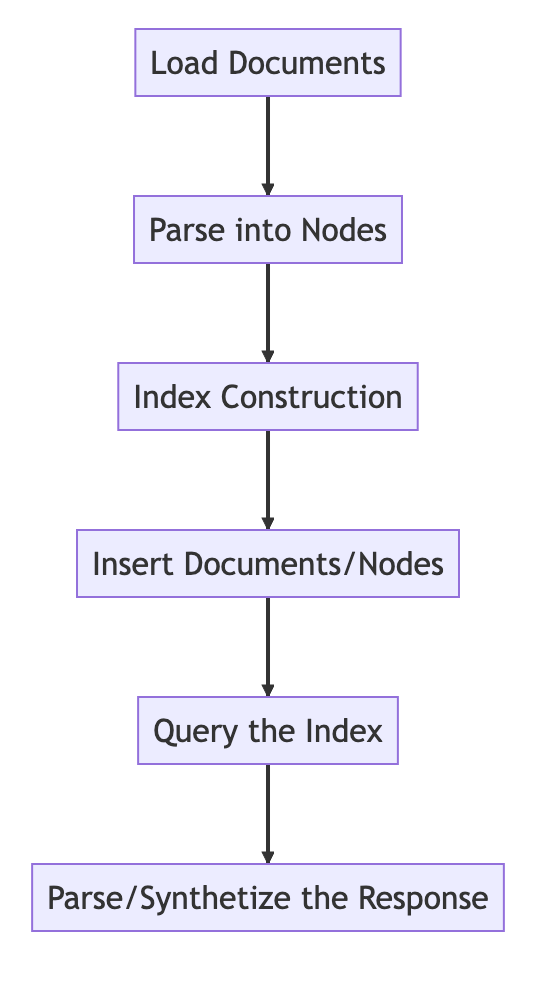

## 1. 使用LlamaIndex

In [ ]:
!pip install llama-index

In [1]:
"""
This module provides an example of using the llama_index library to load and query documents.
"""
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

# Load in data as Document objects, either manually or through a data loader
documents = SimpleDirectoryReader('data').load_data()  # 加载data文件夹下的所有文件
# Parse Document objects into Node objects to represent chunks of data
index = VectorStoreIndex.from_documents(documents)  # 从Document对象中构建索引

# Build an index over the Documents or Nodes
query_engine = index.as_query_engine()  # 构建查询引擎
# The response is a Response object containing the text response and source Nodes
summary = query_engine.query("What is the text about")  # 查询索引
print("What is the data about:")
print(summary)
person = query_engine.query(
    "Extract all the person in the content, format as JSON with a lastname"
    " and first_name property")
print(person)

location = query_engine.query(
    "Extract all the location in the content, format as JSON with a name"
    " and the country")
print(location)

What is the data about:
The text is about the experiences and career decisions of the author, Paul Graham, including his time at art school, his work as a painter, his involvement with Y Combinator, and his return to writing and working on Lisp.
[
  {
    "last_name": "Graham",
    "first_name": "Paul"
  },
  {
    "last_name": "Ulivi",
    "first_name": "Professor"
  }
]
The locations mentioned in the context are:
1. Santa Cruz Mountains
2. New York
3. Cambridge
4. MIT
5. England
6. Piazza San Felice, Florence
7. Piazza San Marco, Florence
8. RISD (Rhode Island School of Design)


## 2. LlamaIndex基本原理

- Chunking（分块）
    - LLamaIndex将输入文档分解为节点的较小块。这个分块是由NodeParser完成的。默认情况下，使用SimpleNodeParser，它将文档分块成句子。
    - 分块过程如下：
        - NodeParser接收一个Document对象列表；
        - 使用spaCy的句子分割将每个文档的文本分割成句子；
        - 每个句子都包装在一个TextNode对象中，该对象表示一个节点；
        - TextNode包含句子文本，以及元数据，如文档ID、文档中的位置等；
        - 返回TextNode对象的列表。
        
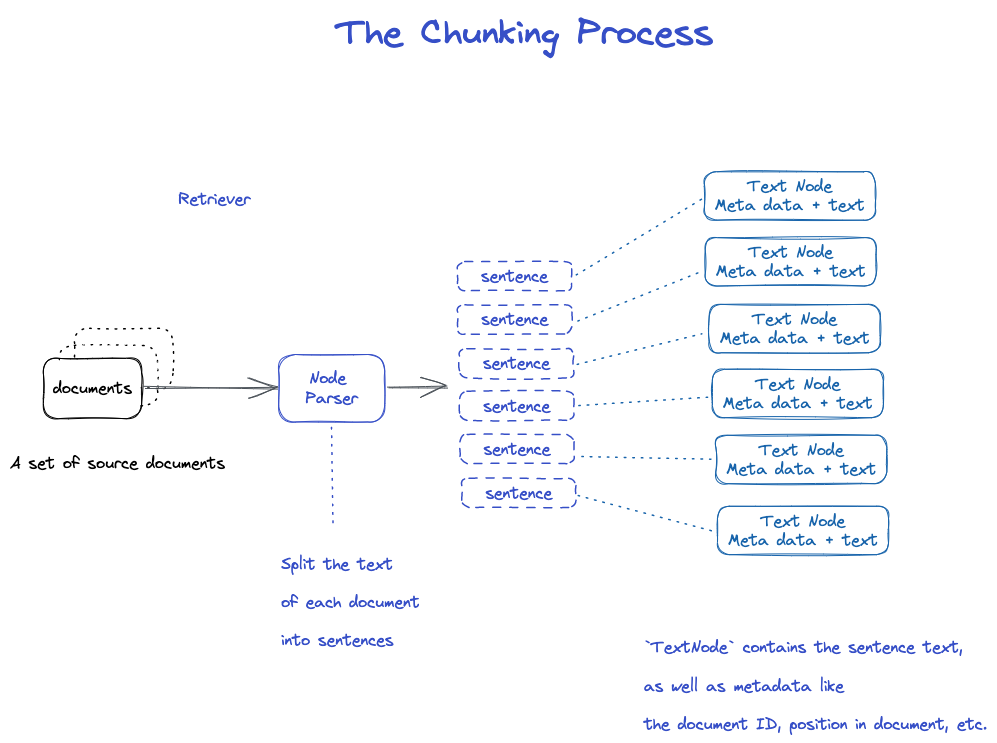

- 将Chunks转换为Embeddings和Nodes
    - 然后将TextNode对象的列表传递给索引以进行嵌入。
        - 对于每个TextNode，使用像all-mpnet-base-v2类似的句子transformer模型将文本编码为embedding；
        - 将此embedding存储在TextNode对象中；
        - TextNode及其embedding和元数据可以在Node对象中被索引。

- 建立索引
    - 在Node对象列表上简历索引。
        - 对于VectorStoreIndex，节点上的文本embedding会存储在FAISS索引中，可以节点上快速进行相似性搜索；
        - 索引还存储每个节点上的元数据，如文档ID、位置等；
        - 节点可以检索某个文档的内容，也可以检索特定文档。

FAISS（Facebook AI相似度搜索）是Facebook AI开发的一个库，可实现高效的相似度搜索和密集向量聚类。它包含的算法可以搜索任何大小的向量集，最多可达数十亿个向量。FAISS是围绕一个索引类型构建的，该索引类型存储一组向量，并提供一个函数，用于通过L2（欧几里得）和/或点积向量比较在其中进行搜索。

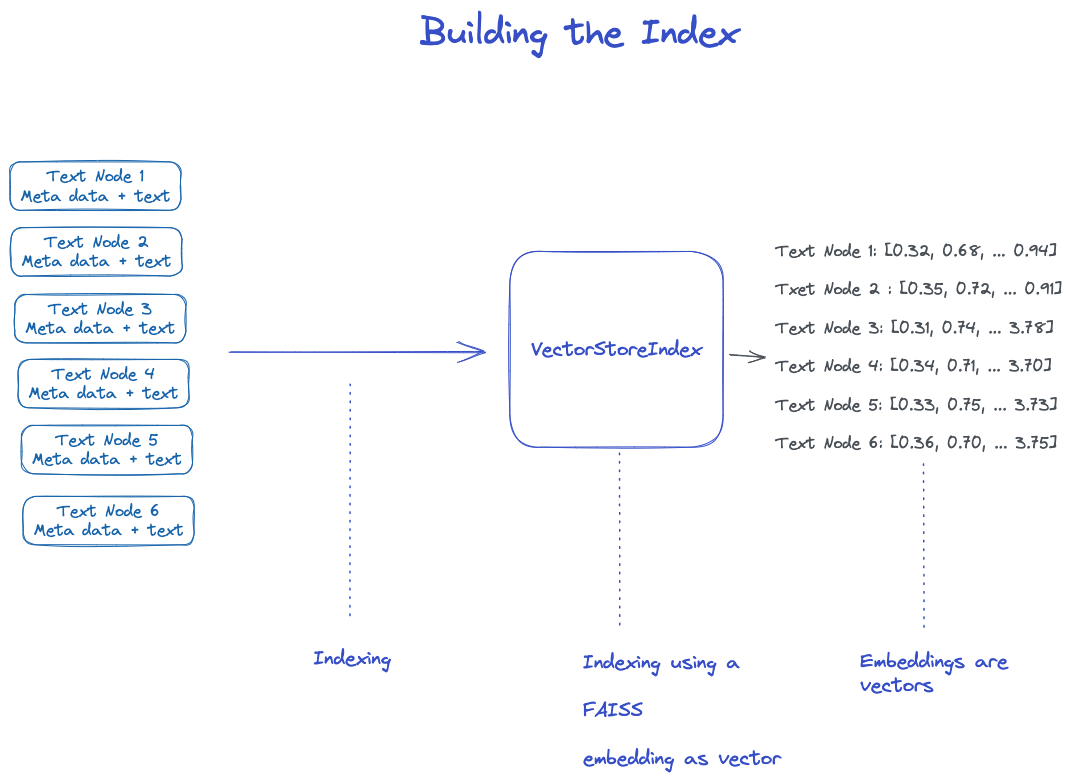

- 查询索引
    - 要查询索引，将使用QueryEngine。
        - Retriever从查询的索引中获取相关节点。例如，VectorIndexRetriever检索embedding与查询embedding最相似的节点；
        - 检索到的节点列表被传递给ResponseSynthesizer以生成最终输出；
        - 默认情况下，ResponseSynthesizer按顺序处理每个节点，每个节点都会调用一次LLM API；
        - LLM输入查询和节点文本来得到最终的输出；
        - 这些每个节点的响应被聚合到最终的输出字符串中。

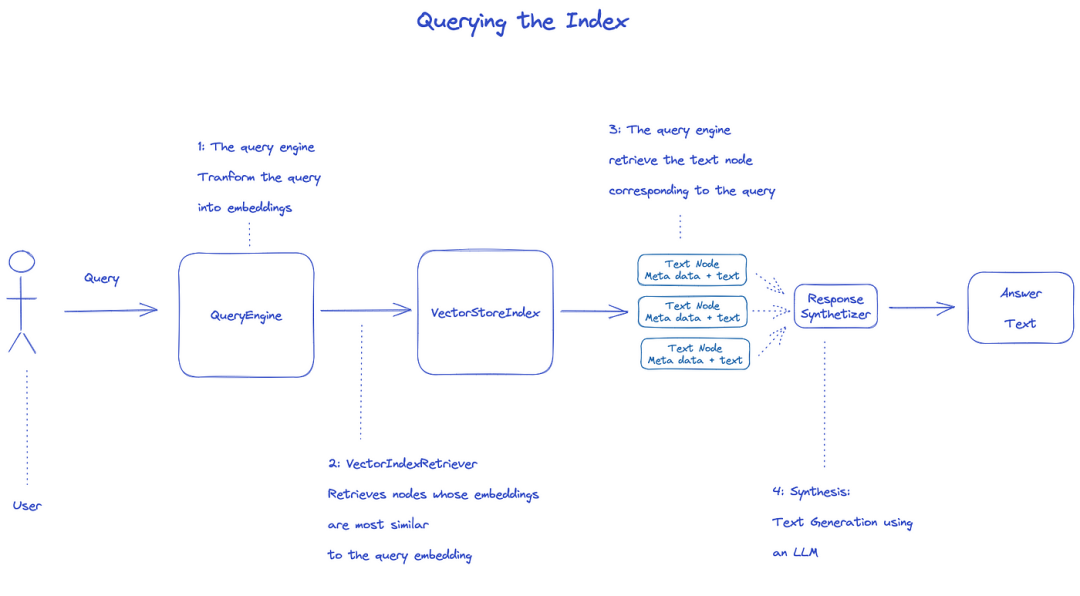